# Homework 4
***Work done by Omirbanu Nurassilova and Ilaria Servadio.***

Show which packages we used:

In [1]:
import requests
import csv
import os
import pandas as pd
import nltk
import numpy as np
os.chdir("C:\\Users\\user\\Documents\\HW4_ADS")

import itertools as it
import math # to calculate the logarithm
from collections import Counter

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#For clustering
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from heapq import nlargest #for return the 3-most similar couples of clusters

# For wordcloud
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

# For scraping
import time
from collections import Counter
from bs4 import BeautifulSoup

## Scraping

In [3]:
# We define this function for the subsequent cleaning of information
def hasNumbers(inputString): 
    return any(char.isdigit() for char in inputString)

In the code below we are showing pages that we will use for scrapping, and after with procedure we will get all links to announcements: 

In [4]:
imma = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="

In [5]:
pages=[imma+str(i) for i in range(1,500)]

In [8]:
pages[498]

'https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=499'

In [9]:
N=len(pages)

In the code below we are getting links to announcemets in each page:

In [10]:
links=[]
for i in range(0,N):
    content=requests.get(pages[i])
    sup=BeautifulSoup(content.text,"html5lib")
    for link in sup.find_all('a'):
        if(hasNumbers(str(link.get('href')))==True and "search" not in link.get('href')
           and ("rilevanza&pag" not in str(link.get('href')))):
            links.append(link.get('href'))

In [11]:
len(links)

12469

So, we scrapped 12469 pages

In [13]:
df=pd.DataFrame(links) #create a dataframe with the pages (row)

In [15]:
df.to_csv('links_all.csv',index=False) #save the dataframe into a csv file for future use

We saved list of links to csv file, and in the srcipt below we implemented the procedure to get all needed columns from each link.

In [49]:
def get_info(link):
    try:
        content=requests.get(link)
        time.sleep(5)
        sup=BeautifulSoup(content.text,"html5lib")
        ans=[]
        a,b,c,d,e,title,descr='','','','','','',''
        for link in sup.find_all('div'):
            if descr=='':
                if link.attrs=={'class': ['col-xs-12', 'description-text', 'text-compressed'],
                                'aria-expanded': 'false', 'role': 'contentinfo'}:
                    descr=link.contents
            

        for link in sup.find_all('h1'):
            if  title=='':
                title=link.contents
            
        for link in sup.find_all('li'):
            if a=='': 
                if(link.get('class')==['features__price']):
                    a=str(link.getText()).split()[1]
            
        for link in sup.find_all('li'):
            if b=='': 
                if(link.get('class')==['features__only-text'] and 
                     'm2superficie' in str(link.getText()) and len(str(link.getText()))>14 
                   and len(str(link.getText()))<18):
                    b=str(link.getText()).split()[0]
            
        for link in sup.find_all('li'):
            if c=='': 
                if('locali' in str(link.getText()) and len(str(link.getText()))==8):
                    c=str(link.getText())[0]
                if c=='':
                    for link in sup.find_all('span'):
                        if c=='':
                            if link.attrs=={'class': ['text-bold']} and '\xa0' in str(link.contents[0]):
                                c=str(link.contents[0])
            
        for link in sup.find_all('li'):  
            if d=='': 
                if('bagni' in str(link.getText()) and len(str(link.getText()))==7):
                    d=str(link.getText())[0]
            
        for link in sup.find_all('li'):
            if e=='': 
                if('piano' in str(link.getText())):
                    e=(str(link.getText()).split()[0])
            
            
        ans=[a.replace(".", ""),b,str(c),str(d),str(e),*title,' '.join(str(descr[1]).split())]
    except:
        ans=[0,0,0,0,0,0,0]
    return ans

In addition, it is clear that we need to **clean data** that we scrapped, that is why we added some means that can help us in this task:
- **Removing stopwords:** if there are words that don’t really have any meaning to our text we can just remove them. This words have sense in our language but in data analysis they are useless;
- **Lemmatizing:** return a real word, so, the end result will be generally some form of synonym or it might be the original word. So, you might end up with a very different word but it will be a similar word with the same meaning;

In [4]:
# We show the packages used to preprocess the pages
import re, string
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()
import io 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
lemma = nltk.wordnet.WordNetLemmatizer() #lemmatization
stop_words = set(stopwords.words('italian'))
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

To the list of stop words we added some tags that was inside description in order to remove them after

In [94]:
stop_words.add("<div>")

In [100]:
stop_words.add("\n")
stop_words.add("</div>")
stop_words.add("http")
stop_words.add("www")
stop_words.add("web")
stop_words.add("div")

In the method below we clean each column with data

In [98]:
def stop_w_p(str(t)):
    t=t.lower()
    t=t.split()
    des1=[]
    for x in t:
        if not x in stop_words:
            x=re.sub("[^a-zA-Z0-9]+", "*", x)
            if "*" in x:
                y=x.split('*')
                #y[0]=ps.stem(y[0])
                y[0]=lemma.lemmatize(y[0])
                des1.append(y[0])
                if len(y)>1:
                    #y[1]=ps.stem(y[1])
                    y[1]=lemma.lemmatize(y[1])
                    des1.append(y[1])
            else:
                #x=ps.stem(x)
                x=lemma.lemmatize(x)
                des1.append(x)
    des1=(' '.join(des1))
    #return ((des1))
    return (word_tokenize(des1))

In [26]:
def cleaned(l1):
    ll=[]
    t=''
    for x in l1[0:2]:
        ll.append(x)
    for x in l1[2:7]:
        t=stop_w_p(x)
        ll.append(' '.join(t))
    return ll

In [46]:
NN=len(links)

In the script below we run the scrapping, and saving each announcement into csv file

In [60]:
for i in range(0,NN):
    data=get_info(links[i])
    df1=pd.DataFrame(data).T
    df1.to_csv("ann%s.csv"%i,index=False)

After completing a scrapping, we merged all data together into one dataframe and csv file

In [136]:
df_1=pd.DataFrame()
for i in range(0,NN):
    data=pd.DataFrame(pd.read_csv("ann%s.csv"%i))
    data=list(data.iloc[0])
    ll=[]
    t=''
    for x in data[0:5]:
        if str(x).isdigit()==True:
            ll.append(x)
        else:
            t=stop_w_p(str(x))
            ll.append(' '.join(t))

    for x in data[5:7]:
        if str(x).isdigit()==True:
            ll.append(x)
        else:
            t=stop_w_p(x)
            ll.append(' '.join(t))
    df_1=df_1.append(pd.DataFrame(ll).T)
    #df1=pd.DataFrame(data)
    #print(data)
df_1.to_csv("full_data_2.csv")

In [139]:
df_1.columns

RangeIndex(start=0, stop=7, step=1)

In [143]:
df_1=pd.DataFrame(pd.read_csv("full_data_2.csv"))

In [151]:
df_1[df_1['0']==0].index

Int64Index([    0,   595,   647,   691,   693,   719,   757,   759,   760,
              783,
            ...
            11908, 11945, 11972, 12044, 12090, 12431, 12433, 12434, 12454,
            12461],
           dtype='int64', length=1036)

In [153]:
df_1=df_1.drop(df_1[df_1['0']==0].index) 

In the code above we removing all rows without price column

In [154]:
df_1.shape

(11433, 8)

In [191]:
type(df_1['piano'][1])

str

In [171]:
df_1=df_1.drop(['Unnamed: 0'],axis=1)

In [172]:
df_1.columns=['price','superficie','locali','bagni','piano','title','description']

In [65]:
pd.set_option('display.max_colwidth', -1)

In [233]:
Data=df_1

Converting column piano to numeric type

In [234]:
Data['Piano']=[pd.to_numeric(x) if str(x).isdigit()==True else 1 for x in Data['piano']]

Dropping all nan values

In [238]:
Data.isna().sum()

price          756
superficie     60 
locali         100
bagni          951
title          0  
description    0  
Piano          0  
dtype: int64

In [240]:
Data=Data.dropna()

In [241]:
Data.shape

(9808, 7)

In [253]:
Data.isna().sum()

price          0
superficie     0
locali         0
bagni          0
title          0
description    0
Piano          0
dtype: int64

In [243]:
Data.columns

Index(['price', 'superficie', 'locali', 'bagni', 'title', 'description',
       'Piano'],
      dtype='object')

In [251]:
Data.to_csv("Final_data.csv")

In [261]:
Data[Data['price']==0] #We show the columns of our data frame

,price,superficie,locali,bagni,title,description,Piano


## Datasets

#### 1) Information
The matrix have this format:
$m_{ij} = value$ where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{price,locali,superficie,bagni,piano\}$. *n* is the number of the announcements

In [246]:
Information1=Data[['price', 'locali', 'superficie',  'bagni','Piano']]
# from the data we take only the column that we need

In [252]:
Information1.to_csv("info1.csv") #transform it into csv file

In [3]:
read = pd.read_csv('info1.csv')
read.head() #head() return the first 5 rows

,Unnamed: 0,price,locali,superficie,bagni,Piano
0,1,225000.0,2.0,50.0,1.0,1
1,2,1350000.0,4.0,200.0,2.0,2
2,3,135000.0,2.0,60.0,1.0,5
3,5,249000.0,2.0,75.0,1.0,1
4,7,279000.0,3.0,110.0,1.0,1


In [250]:
# to get as a matrix
Information1.values

array([[2.25e+05, 2.00e+00, 5.00e+01, 1.00e+00, 1.00e+00],
       [1.35e+06, 4.00e+00, 2.00e+02, 2.00e+00, 2.00e+00],
       [1.35e+05, 2.00e+00, 6.00e+01, 1.00e+00, 5.00e+00],
       ...,
       [2.90e+05, 4.00e+00, 1.25e+02, 2.00e+00, 2.00e+00],
       [1.55e+06, 5.00e+00, 2.85e+02, 3.00e+00, 2.00e+00],
       [1.69e+05, 3.00e+00, 6.10e+01, 1.00e+00, 3.00e+00]])

#### 2) Description
$m_{ij} = tfIdf_{ij}$ where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{word_1, ...,word_m\}$. *n* is the number of the announcements and *m* is the cardinality of the vocabulary.


We read the csv file, from which we take only the column with the ad index and description.

In [3]:
df = pd.read_csv('Final_data.csv', usecols = ['Unnamed: 0','description'])
#for clarity we rename the column 'unnamed: 0'
df = df.rename(columns={'Unnamed: 0': 'Announcements'}) 
df.head() #show the first five rows of our dataframe

,Announcements,description
0,1,papillo eur elegante complesso residenziale ri...
1,2,fleming strada privata via alessandro fleming ...
2,3,torrevecchia adiacente largo arturo donaggio a...
3,5,balduina adiacente piazza giovenale appartamen...
4,7,rif 18101 montagnola via fontanellato pochi pa...


During scraping, when we have some text to work on, we do some `pre-processing`, so when we read our file 'Final_data.csv' it is already clean inside.
However, at this point we decide to remove **all the numbers** that appear in the descriptions such as, for example, telephone numbers or even house numbers, as they do not fit into this analysis.

In [4]:
df['description'] = df['description'].str.replace(r'\d+','')

What we want to do now is to read for each row of our dataframe what is contained in the description column -> we insert every word contained in the description into the *words list* even if the word has already appeared previously.

- `words = list()` is a list of lists where each sublist corresponds to the description of an announcements;
- `words = list(it.chain(*words))` -> convert a nested list into one-dimensional list -> a list that contains all the words
- `len(words)`= 1029709 is the total number of all words that appear in all descriptions. Recall that here the same word can be repeated even more than once.

In [6]:
words = list()
for descr in df['description']:
    element = descr.split()
    words.append(element)
words = list(it.chain(*words))

len(words) 

1029709

Now we decide to take the set of our words: we eliminate all the repetitions of the same word.       As we can see, in this way the total number of words is greatly reduced.

- `wordList`: our list of words taken once contains 21282 elements.

In [7]:
wordList = list(set(words))
len(wordList) 

21282

##### Implement the Tf-Idf:
We begin by writing our function to determine *`tf(t,d)`*: term frequencies is the number of times the term *t* is preempted in the document *d*. 
In our case we are not working with different documents but with one big dataframe in which each line corresponds to the announcement and then to the 'document'.

- `termcountdic = Counter(text)`: a counter is a container that tracks how many times equivalent values are added. So in our case we need to count all the times when the same word appears in the description;
- `len(text)`: represents the total number of words contained in the description of the document(row) we are considering.
- `termcountdic[term] / len(text)`: it's just the number of times the term *t* appears in the document *d* (= df[description-i] where i indicates the row of df). 

$$\huge tf_i,_j = \frac{n_i,_j}{\sum_kn_i,_j}$$


In [9]:
def term_freq(term, text):
    termcountdic = Counter(text)
    return termcountdic[term] / len(text)

At this point, for every word contained in wordList (*where we remember that there are all the words, taken only once, which appear in the descriptions of the ads*) we want to see how many documents appears.

In [10]:
# We initialize a dictionary that has keys for words and 0 as a value.
# d = {word1: 0, word2: 0, ...., wordn: 0}
d = dict.fromkeys(wordList, 0)

for row in df.itertuples(): #read the rows of the df
    desc = row.description.split() #take only the column description
    for w in d: #for each word in the dictionary
        if w in desc: 
        # if the word is contained in the description of the ad (row) we are considering
        # then we increase the value of that word by one
            d[w] += 1
        else: # otherwise we do not increase the value of the words
            pass

len(d) # Obviously the length of d is the same as wordList

21282

In [12]:
N = df.shape[0] 
# N is the number of rows in our dataframe -> so it is the number of ads we are considering
N

9808

It's time to define and explain our *`idf(t,d)`* function (is the inverse frequency):

- `N`: is the number of rows in our dataframe -> so it is the number of ads we are considering;
- `d[word]`: is the number of documents that contain the term *t*. For this we previously created the dictionary *d*;
- `The constant 1`: the addition of the constant 1 to the denominator is optional and has the aim of assigning a value different from 0 to the terms that occur in all the samples;
- `logarithm`: it is used to prevent excessive weight from being given to the infrequent terms in the document. To make the logarithm we have recalled the math module.

$$\huge idf(w) = log(\frac{N}{1 + df_t})$$

In [13]:
def idf(Allword,word):
    return math.log(N/(1 + float(d[word])))

`TFIDF`:

$$\huge tfidf(t,d) = tf(t,d) \times idf(t,d)$$

In [14]:
# tfidf_values = {termID :[TF*IDF]}
tfidf_values = {}
for row in df.itertuples(): #read the rows of the dt
    desc = row.description.split()  #take only the column description
    for word in wordList:
        tf = term_freq(word,desc) #call the function 'term_freq'
        if(word in tfidf_values.keys()):
            tfidf_values[word] +=[tf*idf(words,word)] 
        else:
            tfidf_values[word] = [tf*idf(words,word)]

In [15]:
#we transform the dictionary into a dataframe that has rows for the ads and columns for the words
descriptions = pd.DataFrame.from_dict(tfidf_values) 
idx = 0
new_col = df['Announcements']  
descriptions.insert(loc=idx, column='Announcements', value=new_col)#ad 'Announcements' as first column

In [17]:
#Save the datafrma into CSV file
descriptions.to_csv('Description_matrix.csv', index=False)

In [18]:
#Show our result
descriptions.set_index(['Announcements'], inplace=True)
descriptions.head()

,tamponata,statua,cancella,murarie,riscaldare,attrrezzata,court,piola,propropriet,cane,...,effettuate,verdant,liberti,timoteo,produrre,foglia,murano,individuales,icona,castropignano
Announcements,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Clustering
This step consists in clustering the house announcements using K-means++, and in choose the optimal number of clusters using the *Elbow-Method*. 

When using K-Means algorithm, we need to specify the number of clusters that we need the data set clustered into. So one way of doing this is the use of Elbow method.

Notice that there are 5 columns -> so each announcement sample (row) is a point in 5D space!

In [4]:
data = pd.read_csv('info1.csv') #load the dataset
data.head()

,Unnamed: 0,price,locali,superficie,bagni,Piano
0,1,225000.0,2.0,50.0,1.0,1
1,2,1350000.0,4.0,200.0,2.0,2
2,3,135000.0,2.0,60.0,1.0,5
3,5,249000.0,2.0,75.0,1.0,1
4,7,279000.0,3.0,110.0,1.0,1


In [5]:
# remove the announcements from the DataFrame so only the informations are left
ann = list(data['Unnamed: 0'])
del data['Unnamed: 0']
data.head(2)

,price,locali,superficie,bagni,Piano
0,225000.0,2.0,50.0,1.0,1
1,1350000.0,4.0,200.0,2.0,2


In [6]:
#Extract all the measurements as a 2D array:
samples = data.values
samples

array([[2.25e+05, 2.00e+00, 5.00e+01, 1.00e+00, 1.00e+00],
       [1.35e+06, 4.00e+00, 2.00e+02, 2.00e+00, 2.00e+00],
       [1.35e+05, 2.00e+00, 6.00e+01, 1.00e+00, 5.00e+00],
       ...,
       [2.90e+05, 4.00e+00, 1.25e+02, 2.00e+00, 2.00e+00],
       [1.55e+06, 5.00e+00, 2.85e+02, 3.00e+00, 2.00e+00],
       [1.69e+05, 3.00e+00, 6.10e+01, 1.00e+00, 3.00e+00]])

How many clusters of the house announcements ? We choose a good number of clusters for our dataset (about the information) using the k-means inertia graph.

For each values of k, what we do is:
- 1) Create a k-means instance with k clusters;
- 2) Fit the "kmeans" to the house announcements data samples;
- 3) Append the value of the inertia_ attribute of model to the list Inertia.

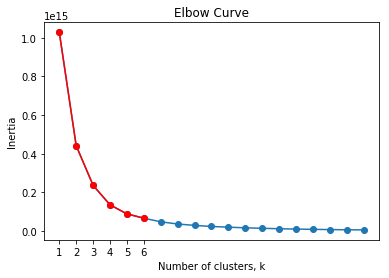

In [7]:
# Choose the optimal number of clusters using the Elbow-Method
ks = range(1, 20)
Inertia = []

for k in ks:
    # 1
    m = KMeans(n_clusters=k,init = 'k-means++') #init:‘k-means++’->method for initialization, defaults to ‘k-means++’
    # 2
    m.fit(samples)
    # 3
    Inertia.append(m.inertia_)
    

ks2 = range(1, 7)
Inertia2 = []
for k in ks2:
    # Create a KMeans instance with k clusters: model
    m2 = KMeans(n_clusters=k,init = 'k-means++')

    # Fit model to samples
    m2.fit(samples)

    # Append the inertia to the list of inertias
    Inertia2.append(m2.inertia_)


plt.plot(ks, Inertia, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.title('Elbow Curve')

plt.plot(ks2, Inertia2, '-o', color = 'r')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks2)
plt.title('Elbow Curve')
plt.show()

As we can see from the graph above, there is no need to take a large number of clusters because, if we look at the blue line, these are the points where the inertia begins to decrease more slowly.
So now let's take a better look and do an analysis focused on fewer clusters (red line).

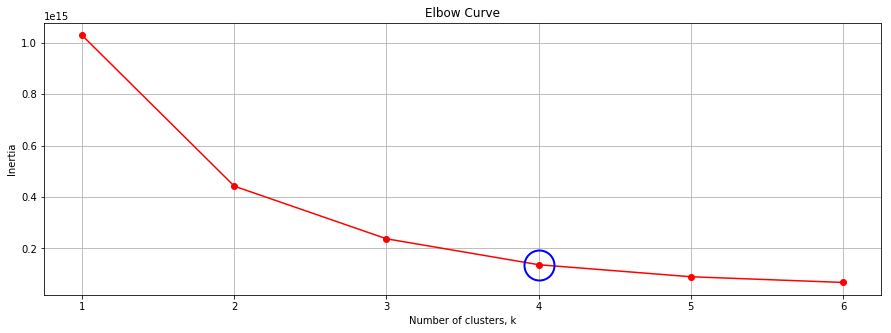

In [54]:
# Plot ks vs inertias
fig = plt.figure(figsize = (15,5))
plt.plot(ks2, Inertia2, '-o', color = 'r')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks2)
plt.title('Elbow Curve')
plt.plot(x[3],y[3], 'o', ms = 30, mec = 'b', mfc= 'none', mew=2)
plt.grid(True)
plt.show()

You can see from the graph that 4 is a good number of clusters, since these are points where the inertia begins to decrease more slowly.

The price,surface and so on have very different scales. In order to cluster this data effectively, we need to standardize these features first.
`StandardScaler()`: as we read from the documentation of Scikit-learn, StandardScaler is standardize features by removing the mean and scaling to unit variance. SO, the idea behind StandardScaler will be a mean value 0 and standard deviation of 1.

In [7]:
scaler = StandardScaler()

In [11]:
#Create an instance of KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, init = 'k-means++')

In [12]:
#Create a pipeline that chains scaler and kmeans.
pipeline = make_pipeline(scaler, kmeans)
#Fit the pipeline 
pipeline.fit(samples)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [13]:
#Obtain the cluster labels for samples by using the .predict() method of pipeline
# And assigning the result to labels
labels1 = pipeline.predict(samples)
labels1

array([0, 3, 2, ..., 1, 3, 0])

In [14]:
#Using pd.DataFrame(), create a DataFrame df with two columns named 'labels' and 'announcements'
df1 = pd.DataFrame({'labels': labels1, 'announcements': ann})
df1.sort_values('labels')
df1.to_csv('Information_cluster.csv', index=False) #Store the result into csv file
df1.head()

,labels,announcements
0,0,1
1,3,2
2,2,3
3,0,5
4,0,7


In [15]:
#We create a dictionary that has the cluster index as a key 
#and and as values have as many elements as are contained in the cluster
clusters = {} #{cluster id: count}
for item in labels1:
    if item in clusters:
        clusters[item] += 1
    else:
        clusters[item] = 1


    
#Print the result:
for key in sorted(clusters): 
    print('Cluster',"%s: %s" % (key, clusters[key]))

Cluster 0: 3832
Cluster 1: 3454
Cluster 2: 1330
Cluster 3: 1192


The result we read above is how the different announcements have been included in the various clusters.

Now, following the same strategy as before, we create description clusters. The only difference is that this time we do not standardize the data because each column represents a word and all the data inserted inside the columns are the tfidf values so there are no different measurement scales between the various columns.

In [16]:
data2 = pd.read_csv('Description_matrix.csv') #Load the data
data2.head()

,Announcements,tamponata,statua,cancella,murarie,riscaldare,attrrezzata,court,piola,propropriet,...,effettuate,verdant,liberti,timoteo,produrre,foglia,murano,individuales,icona,castropignano
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
ann1 = list(data2['Announcements'])
del data2['Announcements']
data2.head(2)

,tamponata,statua,cancella,murarie,riscaldare,attrrezzata,court,piola,propropriet,cane,...,effettuate,verdant,liberti,timoteo,produrre,foglia,murano,individuales,icona,castropignano
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
samples1 = data2.values # convert dataframe to numpy array
samples1 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

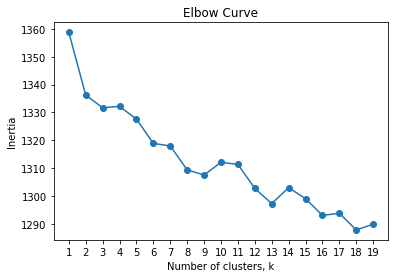

In [5]:
# Choose the optimal number of clusters using the Elbow-Method
ks3 = range(1, 20)
Inertia3 = []

for k in ks3: 
    # 1
    m3 = KMeans(n_clusters=k,init = 'k-means++')
    #init:‘k-means++’->method for initialization, defaults to ‘k-means++’
    # 2
    m3.fit(samples1)
    # 3
    Inertia3.append(m3.inertia_)
    
plt.plot(ks3, Inertia3, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks3)
plt.title('Elbow Curve')
plt.show()

As shown in the plot, 20 clusters this time are not enough for clustering the house announcements, but many more would be needed. We note that inertia does not decrease more slowly from a certain point onwards. However, to correctly calculate the best number of clusters we would have to spend a lot of time (due to the high size of the matrix/dataframe description); moreover, it is not necessary because our **goal** is to make a **comparison** between information clusters and description clusters and to do it we must use the same number of clusters. We decided to use 4 as the number of clusters also for the second matrix. Recall that 4 is the optimal number of clusters for the information matrix that we found using the Elbow-Method

In [19]:
kmeans1 = KMeans(n_clusters=4,init = 'k-means++').fit(samples1)

In [20]:
# cluster id for each data point
labels2 = kmeans1.labels_
labels2

array([3, 3, 0, ..., 3, 3, 3])

In [21]:
df2 = pd.DataFrame({'labels': labels2, 'announcements': ann1})
df2.sort_values('labels')
df2.to_csv('Description_cluster.csv', index=False) #Store the result into csv file
df2.head()

,labels,announcements
0,3,1
1,3,2
2,0,3
3,0,5
4,3,7


In [22]:
#We create a dictionary that has the cluster index as a key 
#and and as values have as many elements as are contained in the cluster
clusters2 = {} #{cluster id: count}
for item in labels2:
    if item in clusters2:
        clusters2[item] += 1
    else:
        clusters2[item] = 1

#Print the result:
for key in sorted(clusters2): 
    print('Cluster',"%s: %s" % (key, clusters2[key]))

Cluster 0: 174
Cluster 1: 117
Cluster 2: 2
Cluster 3: 9515


### Comparison among cluster
***We expect that both datasets will lead to similar clusters. Is this true?***

No, this is not true! As already expressed, four is an optimal number to get clusters from the dataset *Information* but it is not for the other dataset because it would need a larger number of clusters.

The goal of cluster analysis is to find "similar" groups of subjects: in fact, *subjects are separated into groups so that each subject is more similar to other subjects in its group than to subjects outside the group*. Aware of what has been said, since for the description matrix four clusters are not enough, there are also not very similar data among them.

#### Find similar clusters
To check this, use the ***Jaccard-Similarity*** to measure the similarity betweeen the two outputs (information clusters vs description clusters). Return the 3-most similar couples of clusters.

Jaccard similarity index is a measure of similarity for the two sets of data; the formula is:
$$Jaccard Index = \frac{(the \: number \:in\: both \:sets)}{(the\: number \:in\: either \:set)}$$

or 

$$J(X,Y) = \frac{|X \cap Y|}{|X\cup Y|}$$
What we do is count the number of elements that belong to both groups and count the total number of items in both sets (union). Finally,we make the division between the number of shared items and the total number of items.

In [78]:
len(labels1) == len(labels2) #Obviously, because both initial matrices contain the same ads

True

Whereas before we have shown only the number of ads in each cluster, now what we do is to show just what ads are present in each cluster, and we do this thing for both information clusters and description clusters:

In [23]:
keys = [0,1,2,3]
c_info ={key: [] for key in keys}
for row in df1.itertuples(): #read the rows of the df
    announcements = row.announcements #take only the column announcements
    for lab in c_info: #for each word in the dictionary
        if lab == row.labels: 
            c_info[lab] += [announcements]
        else: 
            pass

In [24]:
keys = [0,1,2,3]
c_descr ={key: [] for key in keys}
for row in df2.itertuples(): #read the rows of the df
    announcements = row.announcements #take only the column announcements
    for lab in c_info: #for each word in the dictionary
        if lab == row.labels: 
            c_descr[lab] += [announcements]
        else: 
            pass

Now we define the function to calculate the Jaccard similarity and return the 3-most similar couples of clusters (using a heap data structure):

In [25]:
def jaccard(a,b):
    a = set(a)
    b = set(b)
    return (len(a.intersection(b))/len(a.union(b)))

In [26]:
jaccard_result1 = [] #here we insert both the cluster pair and the jaccard similarity
jaccard_result2 = [] #here only the jaccard similarity
for key,values in c_info.items():
    for k,val in c_descr.items():
        similarity = jaccard(values,val)
        jaccard_result1.append([(key,k),similarity])
        jaccard_result2.append(similarity)

The list *jaccard_result2* contains 16 values because there are 16 possible combinations that can be had between the various clusters.
Remember that $ 0 \leqslant J(X,Y) \leqslant 1 $ : more the value is close to the higher the similarity.

In [27]:
jaccard_result2

[0.013663967611336033,
 0.017783505154639175,
 0.0005219206680584551,
 0.3845435684647303,
 0.020821609454136185,
 0.007902907140841095,
 0.0,
 0.3485494436934595,
 0.015530047265361242,
 0.01047486033519553,
 0.0,
 0.13524547262640008,
 0.01712583767684289,
 0.003834355828220859,
 0.0,
 0.12197422194278529]

In [28]:
most_k = nlargest(3,jaccard_result2)

for el in most_k:
    for element in jaccard_result1:
        if el == element[1]:
            print('Couples of clusters',element[0], 'with Jaccard similarity coefficient equal to', el)

Couples of clusters (0, 3) with Jaccard similarity coefficient equal to 0.3845435684647303
Couples of clusters (1, 3) with Jaccard similarity coefficient equal to 0.3485494436934595
Couples of clusters (2, 3) with Jaccard similarity coefficient equal to 0.13524547262640008


### Word cloud of house descriptions
With this last output we create a *wordcloud* for each couple of clusters. The words that will be represented are those extracted from the description of the houses that are in the relative couple.

A word cloud is a graphical representation of word frequency; in fact, what we want to check is the most frequent words in all the description (text) that we need.

***The strategy that we use is the following:***

1) For each couple of clusters that we got before, we consider only the announcements that belong to both clusters of the pair. To do this we use:`set(cluster information).intersection(set(cluster description)`;

2) Once we have all the announcements belonging to the couple, we upload the .csv file that contains the descriptions of the ads -> `pd.read_csv()` taking only the columns we need;

*Note*: the descriptions have already been **pre-processed** during the scraping phase so there is no need to repeat this operation. The only thing we do is to delete all the numbers from the descriptions because we are not interested in the wordcloud.

3) Next step is to store all the words of the descriptions (of the ads that are part of both clusters) within a list. -> in this way we will have all of words to calculate which words are the most frequent amoung the given text;

In [29]:
# This is step 2 of our strategy:
# Load the data:
description = pd.read_csv('Final_data.csv', usecols = ['Unnamed: 0','description'])
#for clarity we rename the column 'unnamed: 0'
description = description.rename(columns={'Unnamed: 0': 'Announcements'}) 
description.head(2) #show the first two rows of our dataframe

,Announcements,description
0,1,papillo eur elegante complesso residenziale ri...
1,2,fleming strada privata via alessandro fleming ...


In [30]:
description['description'] = description['description'].str.replace(r'\d+','') #delete the numbers

In [31]:
#Now let's create our mask:
# to make sure that our mask works, let's take a look at it in the np array form:
house_mask = np.array(Image.open("C:/Users/Admin/Desktop/Homework_4/img_67126.png"))
house_mask
#The way the masking functions works is that it requires all white part of the mask should be 255 not 0(integer type).
#This value represents the "intensity" of the pixel.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [32]:
#First, you use the transform_format() function to swap number 0 to 255.
#NB: to do this we followed the tutorial on the text of the hw
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [33]:
# Transform our mask into a new one that will work with the function:
transformed_mask = np.ndarray((house_mask.shape[0],house_mask.shape[1]), np.int32)

for i in range(len(house_mask)):
    transformed_mask[i] = list(map(transform_format, house_mask[i]))

In [34]:
# Check the expected result of your mask
transformed_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

The number of ads that we consider for couple of clusters (0, 3) is: 3707
There are 358111 words, even repeated,in descriptions  of couple of clusters (0, 3)
There are 117293 words in the combination of all description.  of couple of clusters (0, 3)
The number of ads that we consider for couple of clusters (1, 3) is: 3352
There are 367118 words, even repeated,in descriptions  of couple of clusters (1, 3)
There are 119653 words in the combination of all description.  of couple of clusters (1, 3)
The number of ads that we consider for couple of clusters (2, 3) is: 1292
There are 127327 words, even repeated,in descriptions  of couple of clusters (2, 3)
There are 73995 words in the combination of all description.  of couple of clusters (2, 3)


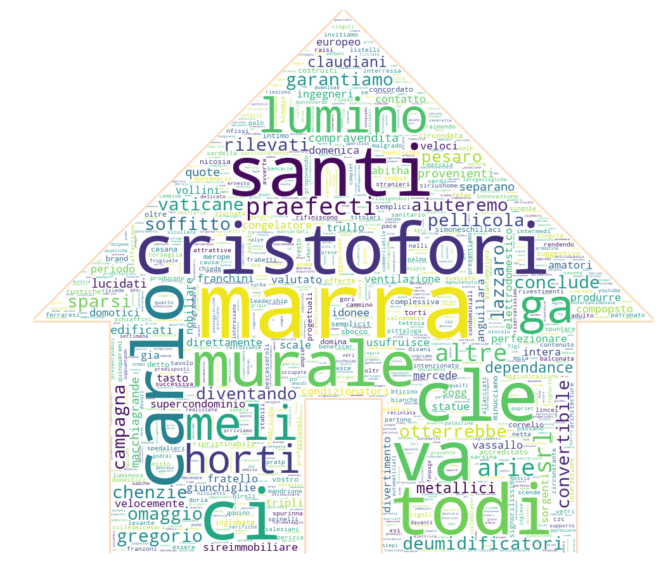

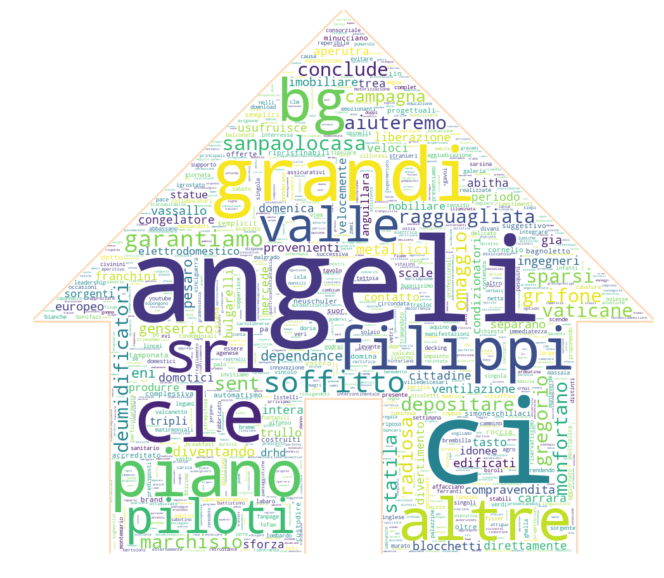

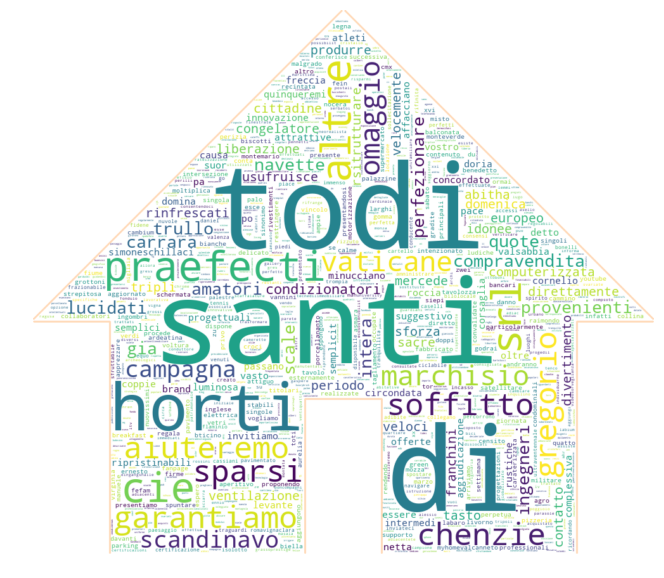

In [35]:
q = [[0,3],[1,3],[2,3]] #pairs of cluster
count = 1 #for save the image
for i,j in q:
    #This is step 1 of our strategy (read above):
    u = set(c_info[i]) #take all the announcements that are part of the information cluster i
    k = set(c_descr[j]) #take all the announcements that are part of the description cluster j
    docs = u.intersection(k) # the announcements that belong to both clusters of the pair
    print('The number of ads that we consider for couple of clusters',(i,j),'is:',len(docs))
    # This is step 3 of our strategy (read above):
    wordcloud_clust = []
    for row in description.itertuples(): #read the rows of the df
        for d in docs:
            if row.Announcements == d: #if it's the ad we need
                desc = row.description.split() #take only the column description
                wordcloud_clust.append(desc)
    wordcloud_clust = list(it.chain(*wordcloud_clust)) #remove the nested lists
    print('There are {} words, even repeated,in descriptions'.format(len(wordcloud_clust)),
          ' of couple of clusters',(i,j))
    # Now we remove duplicates:
    w = list(set(wordcloud_clust))
    w = ' '.join(w) #from list to string
    print ("There are {} words in the combination of all description.".format(len(w)),
           ' of couple of clusters',(i,j))
    # Create a word cloud image
    wc = WordCloud(background_color="white", max_words=1000, mask=transformed_mask,
                  contour_width=3, contour_color='peachpuff')
    # Generate a wordcloud
    wc.generate(w)
    # show
    plt.figure(figsize=[20,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    # Save the image in the img folder:
    wc.to_file('C:/Users/Admin/Desktop/Homework_4/image'+str(count)+'.png')
    count += 1

# 2) Find the duplicates!
***Work done by Omirbanu Nurassilova and Ilaria Servadio.***

Show which packages we used:

In [1]:
import operator
import os
import math
import functools
os.chdir("C:\\Users\\user\\Documents\\HW4_ADS")

### "AABA" = "AAAB"
The **goal** is to check whether there are some duplicate strings.
Our definition of duplicate is that the two strings have the same characters, order is not important. Thus, `"AABA" = "AAAB"`.

Convert the string containing the password to a large number:

In [2]:
def conv(st): # here we sort all characters inside word and the calculate its numeric expression
    ww=1
    for x in sorted(st): 
        ww=ww*ord(x) # ord(x) return an integer representing the Unicode code point of the character 
    return ww

Use a hash function to map the number to a large range: here we map large number from "conv" function into number with 12 characters.

In [3]:
def my_hash(LN): # here we map large number from "conv" function into number with 12 characters
    tablespace=101010101010
    try:
        val=LN//tablespace + LN%tablespace
        if val < tablespace:
            return val
        else:
            return my_hash(val)
    except:
        return LN

Finally, we run code below to get all number of unique values and duplicates:

In [9]:
set_of_hash=set()
duplicates=[]
file = open("passwords2.txt", "r")
for line in file:
    #line are one hundred and ten million (that is, on every line of the file there is a password)
    LN=conv(line) #converting the string into a number
    hashnum=my_hash(LN) #apply hash function
#If the number is already in the set it means that what I am considering now is a duplicate
#so I do not add it to the set of hashnu, but I add it to a list where I insert all the duplicates
    if hashnum in set_of_hash:
        duplicates.append((hashnum, line)) #(number, password)
    else:
        set_of_hash.add(hashnum)

After runnig of this code we get that:

- *`len(set_of_hash)`* : it gives us back the number of all the different passwords from each other; remember that in this case the order of the characters does not matter;
- *`len(duplicates)`* : the number of duplicates that were found;
- *`len(set_of_hash)+len(duplicates)`*: return $110000000$, this means that we have read the whole file password2.txt;
- *`dp = set(duplicates1) & m=len(dp)`*: m is number of items inside list of unique values that has a duplicates;

Sometimes happen that two strings with different characters are hashed to the same value, in this case we get **False Positive**. How many false positives have we identified with our code?
We know that in the file there are 10M duplicates but the duplicates we found are 10242985 so the number of False Positive is: $ 10242985 - 110000000  = 99757015$

In [10]:
len(set_of_hash) # unique values

99757015

In [11]:
len(duplicates) # number of duplicates

10242985

In [12]:
len(set_of_hash)+len(duplicates)

110000000

In [20]:
duplicates1=duplicates
dp=set(duplicates1)
m=len(dp)
m # this is number of items inside list of unique values that has a duplicates

10242366

### "AABA" != "AAAB"
Now we do the same thing as before but the order of the characters must be put into account. 

In [8]:
def conv1(st): #Convert the string containing the password to a large number
    m=st.index(max(st))+19
    mi=st.index(min(st))+19
    return (m**mi)*(functools.reduce(operator.mul, st))

Obviously we could have left the same hash function that we use before but we decided to create another one to speed up the code ... or at least give it a try! In fact, this time we don't read the passwords as a strings but as *bytes*.

In [9]:
def my_hash_1(LN):
    t=87178291199
    return (LN//t)%t+(LN%t)

Let's try to show how our conv1 function works. Taking "ana" and "naa" returns two different numbers between them because it takes into account the order of the characters.

In [10]:
my_hash_1(conv("ana"))

68740261025

In [12]:
my_hash_1(conv("naa"))

80879960018

In [13]:
set_of_hash=set()
duplicates=0
file = open("passwords2.txt", "rb") # here we read string as bytes
for line in file:

    LN=conv1(line)
    hashnum=my_hash_1(LN)
    
    if hashnum in set_of_hash:
        duplicates+=1 # Count the duplicates
    else:
        set_of_hash.add(hashnum)

After execution of script above we get the following:

In [14]:
duplicates # number of duplicates

5292013

In [15]:
len(set_of_hash) # unique values

104707987

In [15]:
len(set_of_hash) + duplicates #the total number of passwords

110000000

In this second case, we know how many duplicates are (5292013) but we can not estimate the number of false positives, but we can assume their presence.